In [1]:
# Explainable Machine Learning for Classification of Anemia Subtypes Using Complete Blood Count Data

#Anemia is a major public health problem in India. Differentiating between anemia subtypes such as iron deficiency anemia and thalassemia trait is clinically important but often challenging using routine blood tests alone.

#This study aims to develop an interpretable machine learning model to classify anemia subtypes using complete blood count (CBC) parameters.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC



In [3]:
#1. loading the dataset
df = pd.read_csv("cbc_anemia.csv")
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374 entries, 0 to 373
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   S. No.     364 non-null    float64
 1   Age        364 non-null    float64
 2   Sex        364 non-null    float64
 3     RBC      365 non-null    object 
 4   PCV        365 non-null    object 
 5   MCV        365 non-null    object 
 6   MCH        365 non-null    object 
 7    MCHC      364 non-null    float64
 8    RDW       365 non-null    object 
 9   TLC        365 non-null    object 
 10   PLT /mm3  365 non-null    object 
 11   HGB       365 non-null    object 
dtypes: float64(4), object(8)
memory usage: 35.2+ KB


In [4]:
#2 check missing values
print(df.columns)
print (df.describe())
df.isnull().sum()

Index(['S. No.', 'Age      ', 'Sex  ', '  RBC    ', 'PCV', 'MCV  ', 'MCH',
       ' MCHC  ', ' RDW    ', 'TLC', ' PLT /mm3', ' HGB '],
      dtype='object')
           S. No.   Age             Sex        MCHC  
count  364.000000  364.000000  364.000000  364.000000
mean   182.500000   44.917582    0.442308   32.053407
std    105.221988   18.780854    0.497344    2.801790
min      1.000000   11.000000    0.000000   23.600000
25%     91.750000   28.000000    0.000000   30.300000
50%    182.500000   44.500000    0.000000   31.700000
75%    273.250000   60.000000    1.000000   33.300000
max    364.000000   89.000000    1.000000   50.200000


S. No.       10
Age          10
Sex          10
  RBC         9
PCV           9
MCV           9
MCH           9
 MCHC        10
 RDW          9
TLC           9
 PLT /mm3     9
 HGB          9
dtype: int64

In [29]:
# Clean column names (remove spaces)
df.columns = df.columns.str.strip()

In [6]:
print(df.columns.tolist())

['S. No.', 'Age', 'Sex', 'RBC', 'PCV', 'MCV', 'MCH', 'MCHC', 'RDW', 'TLC', 'PLT /mm3', 'HGB']


In [7]:
blood_cols = ["RBC", "PCV", "MCV", "MCH", "MCHC", "RDW", "TLC", "HGB"]

for col in blood_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")

In [8]:
df[blood_cols].isnull().sum()

RBC     10
PCV     10
MCV     10
MCH     10
MCHC    10
RDW     10
TLC     10
HGB     10
dtype: int64

In [9]:
df = df.dropna(subset=blood_cols)

In [10]:
#3. Creating anemia subtype labels
#Mentzer Index is a hematological tool used to differentiate between iron deficiency anemia (IDA) and beta thalassemia trait (βTT)
#it is calculated using mcv/rbc(mean corpuscular volume/ red blood cells
df["mentzer_index"] = df["MCV"] / df["RBC"]

#create anemia type label 
def assign_anemia_type(row):
    if row["Sex"]==0: #female
        hb_cutoff=12
    else: 
        hb_cutoff=13 #male
    if row["HGB"] < hb_cutoff:
        if row["mentzer_index"] > 13:
            return "Iron Deficiency Anemia"
        else:
            return "Thalassemia Trait"
    else:
        return "Non Anemic"

df["anemia_type"] = df.apply(assign_anemia_type, axis=1)

#checkiing class distributions
df["anemia_type"].value_counts() #tells how many are anemic, thalessemic or normal

        

anemia_type
Iron Deficiency Anemia    193
Non Anemic                166
Thalassemia Trait           5
Name: count, dtype: int64

In [30]:
#label encoding
label_encoder = LabelEncoder()
df["anemia_label"] = label_encoder.fit_transform(df["anemia_type"])
print(label_encoder.classes_)

['Iron Deficiency Anemia' 'Non Anemic' 'Thalassemia Trait']


In [31]:
#feature selection
features =["RBC", "PCV", "MCV", "MCH", "MCHC", "RDW", "TLC", "PLT /mm3", "HGB", "mentzer_index" ]
X=df[features]
Y=df["anemia_label"]


In [32]:
#train-test split
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size =0.2, random_state=42, stratify=Y
)

In [33]:
#scale data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [34]:
#Logistic Regression (medical baseline)
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, Y_train)
y_pred_lr = log_reg.predict(X_test)

In [35]:
#Random Forest(strong nonlinear model)
rf = RandomForestClassifier(
    n_estimators = 200,
    random_state = 42,
    class_weight = "balanced"
)
rf.fit(X_train, Y_train)
y_pred_rf = rf.predict(X_test)

In [36]:
svm = SVC(kernel = "rbf", class_weight = "balanced")
svm.fit(X_train, Y_train)
y_pred_svm = svm.predict(X_test)

In [18]:
#7. evaluating models properly by generarting reports
#logistic regression model report
print("Logistic Regression Report")
print(classification_report(Y_test, y_pred_lr))

Logistic Regression Report
              precision    recall  f1-score   support

           0       0.86      0.92      0.89        39
           1       0.90      0.79      0.84        33
           2       0.50      1.00      0.67         1

    accuracy                           0.86        73
   macro avg       0.75      0.90      0.80        73
weighted avg       0.87      0.86      0.86        73



In [19]:
#Random Forest Report 
print("Random Forest Report")
print(classification_report(Y_test, y_pred_rf))

Random Forest Report
              precision    recall  f1-score   support

           0       0.90      0.90      0.90        39
           1       0.88      0.85      0.86        33
           2       0.50      1.00      0.67         1

    accuracy                           0.88        73
   macro avg       0.76      0.92      0.81        73
weighted avg       0.88      0.88      0.88        73



In [20]:
#SVM report
print("SVM Results")
print(classification_report(Y_test, y_pred_svm))

SVM Results
              precision    recall  f1-score   support

           0       0.80      0.92      0.86        39
           1       0.89      0.73      0.80        33
           2       1.00      1.00      1.00         1

    accuracy                           0.84        73
   macro avg       0.90      0.88      0.89        73
weighted avg       0.84      0.84      0.83        73



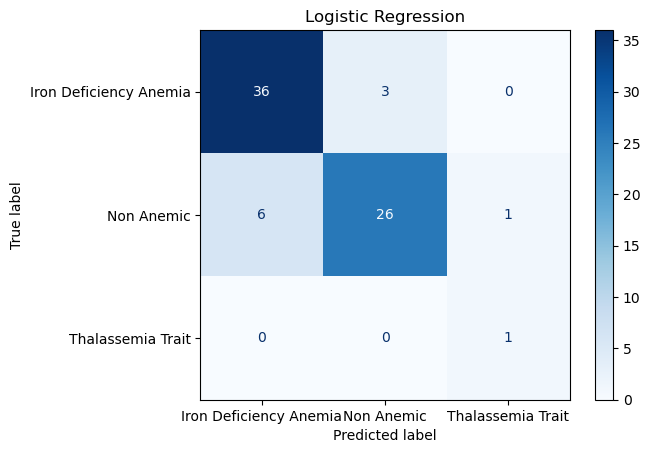

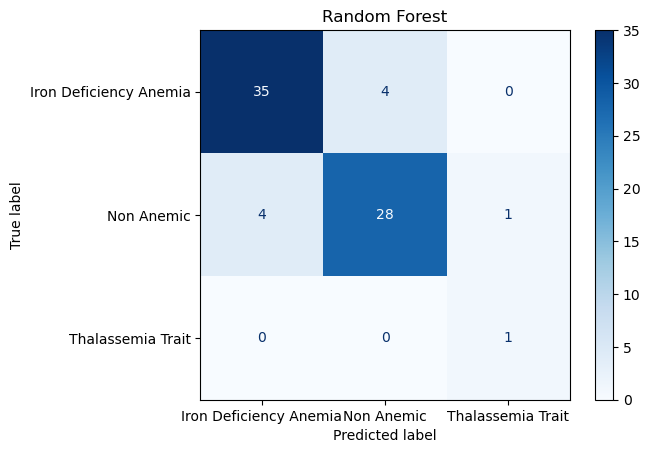

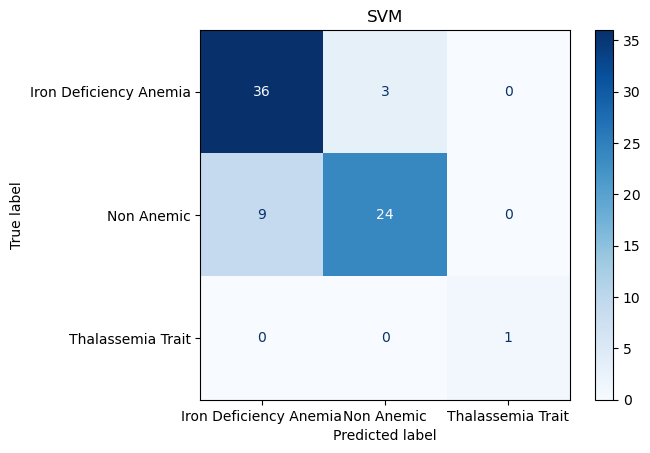

In [21]:
models = {
    "Logistic Regression": y_pred_lr,
    "Random Forest": y_pred_rf,
    "SVM": y_pred_svm
}
for name, preds in models.items():
    disp = ConfusionMatrixDisplay.from_predictions(
        Y_test, preds, 
        display_labels=label_encoder.classes_,
        cmap="Blues"
        
    )
    plt.title(name)
    plt.show()

In [22]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42, k_neighbors=2)
X_resampled, Y_resampled = smote.fit_resample(X, Y)

print("Before SMOTE:", Y.value_counts())
print("After SMOTE:", pd.Series(Y_resampled).value_counts())

Before SMOTE: anemia_label
0    193
1    166
2      5
Name: count, dtype: int64
After SMOTE: anemia_label
2    193
1    193
0    193
Name: count, dtype: int64


In [37]:
#splitting data into train sets
X_train, X_test, Y_train, Y_test = train_test_split(
    X_resampled, Y_resampled, test_size=0.2, random_state=42, stratify=Y_resampled
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (463, 10)
Test shape: (116, 10)


In [38]:
#choosing random forest classifier model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, Y_train)

Y_pred = clf.predict(X_test)

print(confusion_matrix(Y_test, Y_pred))
print(classification_report(Y_test, Y_pred))

[[33  5  0]
 [ 0 38  1]
 [ 0  0 39]]
              precision    recall  f1-score   support

           0       1.00      0.87      0.93        38
           1       0.88      0.97      0.93        39
           2       0.97      1.00      0.99        39

    accuracy                           0.95       116
   macro avg       0.95      0.95      0.95       116
weighted avg       0.95      0.95      0.95       116



In [39]:
#evaluating the model
from sklearn.model_selection import cross_val_score
scores = cross_val_score(clf, X_resampled, Y_resampled, cv=5, scoring = 'f1_macro')
"CV F1-Score", scores.mean()
print("5-fold CV F1-macro scores:", scores)
print("Mean CV F1-macro score:", scores.mean())

5-fold CV F1-macro scores: [0.96510434 0.95659282 0.93038984 0.93121693 0.9390237 ]
Mean CV F1-macro score: 0.9444655271408253


<Axes: >

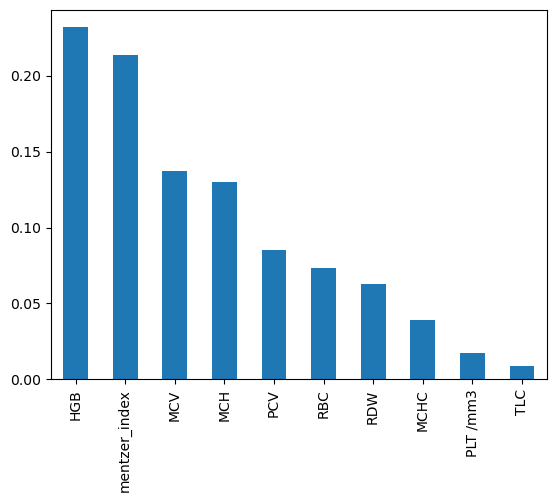

In [40]:
feature_importance = pd.Series(clf.feature_importances_, index=X.columns)
feature_importance.sort_values(ascending = False).plot(kind='bar')

In [41]:
import joblib
joblib.dump(clf, "anemia_model.pkl")
print("Model loaded successfully")

Model loaded successfully


In [42]:
#save the evaluation results
import numpy as np
np.savetxt("confusion_matrix.csv", confusion_matrix(Y_test, Y_pred), delimiter=",")
feature_importance.to_csv("feature_importance.csv")